In [185]:
import torch as tr 
import torch.optim as optim
import torch.distributions as distrib
import torch.distributions.transforms as transform
from torch.utils.data import DataLoader
from torch import nn

import numpy as np 
import matplotlib.pyplot as plt

In [ ]:
device = tr.device("cuda:0" if tr.cuda.is_available() else "cpu")
device

# Density estimation

We can think of a probability density at $x\in \mathbb{R}^d$ as a measure of how often the process generates data around $x$ per unit volume. In particular be $B_\epsilon (x)$ a ball centered around $x$ of radius $\epsilon$ and be $|B_\epsilon(x)|$ its volume. Informally we can say that the probability density at $x$ is given by
$$ p(x) = \frac{P(x' \in B_\epsilon(x))}{|B_\epsilon(x)|} \quad \text{for} \quad \epsilon \rightarrow 0$$
where $P(x' \in B_\epsilon(x))$ is the probability that we observe data in the epsilon ball around $x$.

Why we need densities? Simply because its crucial for Bayesian inference and we need them to compute expectations and other important moments. In the context of likelihood free inference oberseve that the likelihood is a density, hence we may just estimate it.

**Problem:** Estimating densities in high dimensions becomes a hard problem, naive methods as e.g. histograms break down as the dimensionality increases. To see this just consider that the volume of an euclidean n-ball is given by 
$$ | B_\epsilon(x) |= \frac{(\pi^{1/2}\epsilon)^D}{\Gamma (\frac{D}{2} + 1)}$$
That is the volume decreases to zero of increasing dimension. In practise we have to make the ball lare enough to contain at least one datapoint. Otherwise the density will be zero.

There are several traditional methods:
* Simple paramteric modeles as e.g. mixture models 
* Histogramms 
* Non paramteric modeles as kernel density estimates.

We will discuss neural density estimation.

## 1) Parametric neural conditional density estimation: Mixture Density Networks 

A probability density has several restriction as it has to  be strictly positive and integrate to one. Hence instead of learning the density directly we will learn the paramters of an expressive probabilistic model. Here we will learn the paramters of a mixture model of $K$ Gaussian components given by 
$$ q_\phi(\theta|x) = \sum_{k=1}^K \pi_k \mathcal{N}(\theta|\mu_k, \Sigma_k)$$
where $\pi = \{ \pi_1, \dots, \pi_K\}$ are the mixing coeffiients and $\mu = \{\mu_1, \dots, \mu_K\}, \Sigma = \{\Sigma_1, \dots, \Sigma_K\}$ the means and covariance matrices of each component.

These parameters will be computed by a feedforward neural network $y = f_W(x)$. Then the mixing coefficients are given by 
$$ \pi = softmax(W_\pi y + b_\pi)$$
The softmax ensures that the mixing coefficients are strictly positive and sum to one. Similarly the mean is given by 
$$ \mu_k = W_{\mu_k}y + b_{\mu_k}$$
For the covariance matrix, we will actually learn the square root of the inverse (precision matrix) $\Sigma_k^{-1} = \Lambda_k = S_k^TS_k$. This we will parameterize by 
$$ diag(S_k) = exp(W_{diag(S_k)}y + b_{diag(S_k)}) \quad UTri(S_k) = W_{UTri(S_k)}y + b_{UTri(S_k)} \quad LTri(S_k) = 0$$
Apart for ensuring symmetry and postive definitness the above paramterization allows for efficient calculation of the determinat, which is necessary for calculating the Gaussian density
$$ -\frac{1}{2}\log \det(\Lambda_k) = sum(W_{diag(S_k)}y + b_{diag(S_k)})$$
Given training data $\{\theta_n, x_n\}$, training the MDN by maximum likelihood amounts to maximizing the average log probability
$$ \frac{1}{N}\sum_{n=1}^N \log q_\phi(\theta_n|x_n)$$

In [ ]:
A = tr.zeros(10,2,2)

In [25]:
class MDN(nn.Module):
    def __init__(self,input_dim, output_dim, K=20,hidden_dim=100, hidden_layers=3):
        super(MDN,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.K = K

        layers = [nn.Linear(input_dim,hidden_dim), nn.ReLU()]
        for _ in range(hidden_layers):
             layers += [nn.Linear(hidden_dim,hidden_dim), nn.ReLU(), nn.Dropout(p=0.05),nn.BatchNorm1d(hidden_dim)]

        self.network = nn.Sequential(*layers)
        self.fc_mixture = nn.Linear(hidden_dim, K)
        self.fc_mean = nn.Linear(hidden_dim,output_dim*K)
        self.fc_stddiag = nn.Linear(hidden_dim, output_dim*K)
        self.fc_stdtril = nn.Linear(hidden_dim,output_dim*output_dim*K)
        self.stdtril_mask = tr.tril(tr.ones(output_dim,output_dim), -1)
            
    def mixtures(self, h):
        N = h.size(0)
        pis = self.fc_mixture(h)
        return pis.reshape(N, self.K)

    def means(self, h):
        N = h.size(0)
        mus = self.fc_mean(h)
        if self.output_dim > 1:
            return mus.reshape(N,self.K, self.output_dim)
        else:
            return mus.reshape(N,self.K)

    def precisions(self, h):
        N = h.size(0)
        if self.output_dim > 1:
            diag = tr.functional.F.softplus(self.fc_stddiag(h)).reshape(N,self.K, self.output_dim) + 1e-3
            tril = self.fc_stdtril(h).reshape(N,self.K, self.output_dim, self.output_dim)
            diag = tr.diag_embed(diag)
            tril = tril*self.stdtril_mask
            std = diag + tril 
            return std@tr.transpose(std,2,3)
        else:
            std = tr.exp(self.fc_stddiag(h)).reshape(N,self.K)
            return std

    
    def forward(self,x):
        x = x.view(-1, self.input_dim)
        h = self.network(x)
        logpis = self.mixtures(h)
        mus = self.means(h)
        precisons = self.precisions(h)

        mixs = distrib.Categorical(logits=logpis)
        if self.output_dim > 1:
            components = distrib.MultivariateNormal(mus, precision_matrix=precisons)
        else:
            components = distrib.Normal(mus,precisons)
        gmm = distrib.MixtureSameFamily(mixs,components)

        return gmm

Lets first try a simple regression problem. First be the distribution of $x$ a Gaussian mixture given by
$$ p(x) = 0.4\cdot \mathcal{N}(x;-2,1) + 0.6\cdot \mathcal{N}(x;1,1)$$

In [45]:
#mix = distrib.Categorical(probs=tr.tensor([0.4,0.6]))
#comp = distrib.Normal(tr.tensor([-2.,1.]), tr.ones(2))
#gmm = distrib.MixtureSameFamily(mix, comp)
#x = tr.linspace(-5,5,1000)
#plt.plot(x, gmm.log_prob(x).exp())
#X= gmm.sample_n(1000)
#_=plt.hist(X,density=True,alpha=0.5, bins=20)

Lets say what we actually observe is a variable $y$ that is dependent on $x$ i.e.
$$y = \log((x+ \epsilon)^2) \quad \epsilon \sim \mathcal{N}(0,1)$$ 
This is typically intractable with standard methods as we have a nonlinear transformation. We want to estimate
$$ p(y|x) \approx q_\phi(y|x)$$

In [215]:
def simulator(x):
    return tr.log((x+tr.randn(x.shape))**2)

In [216]:
X = tr.randn(10000)

In [224]:
y = simulator(X)

In [225]:
data = []
for xi,yi in zip(X,y): data.append([xi,yi])
data = DataLoader(data, batch_size=1000, shuffle=True)

In [226]:
model = MDN(1,1,K=15,hidden_dim=100)

In [227]:
def train(model,data, epochs = 30):
    model.train()
    optimizer = optim.Adam(model.parameters())
    for i in range(epochs):
        for xi,yi in data:
            optimizer.zero_grad()
            p_x_y = model(xi)
            loss = -p_x_y.log_prob(yi).mean()
            loss.backward() 
            optimizer.step()
    model.eval()

In [228]:
train(model,data)

X_model = gmm.sample_n(100000)
model.eval()
p_y_x = model(X_model)
y_model = p_y_x.sample()

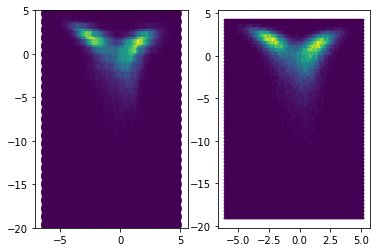

In [229]:
X_true = gmm.sample_n(100000)
y_true = tr.log((X_true + tr.randn(100000))**2)

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.hexbin(X_model, y_model)
ax1.set_ylim(-20,5)
ax2.hexbin(X_true, y_true)

So that woreked rather good.

## 2) Likelihood free inference with MDN

If we simualte enough paramters from hte prior, the density estimator $q_\phi$ would learn a conditional of the joint prior model over paramters and data, which is exacly the posterior $p(\theta|x)$.

However if samples from the prior do not agree well with data, then we will learn a rather bad posterior as only a few samples fall in regions where we would assign high probability mass. Thus we generate paramters $\theta$ form a proposal $\tilde{p}(\theta)$, as we are mainly interested in the regions of the posterior that explain the data well.

Problematically this would bias the posterior as we no longer darw from the prior, but from the proposal. Hence we need to importance reweight the the posterior by 
$$ \hat{p}(\theta|x=x_0) \sim \frac{p(\theta)}{\tilde{p}(\theta)}q_\phi(\theta|x_0)$$


As the MDN procuces a Gaussian Miture Model, we can analytically determine the posterior if the proposal be Gaussian and the prior is Gaussian or Uniform. If the prior is Uniform everywhere (improper), then the estimated posterior becomes
$$ \hat{p}(\theta|x) \propto \frac{q_\phi(\theta|x_0)}{\tilde{p}(\theta)}$$
Since $q_\phi$ is a mixture of Gaussians and $\tilde{p}$ is Gaussian that is
$$ q_\phi(\theta|x) = \sum_{k} \pi_k \mathcal{N}(\theta|m_k,S_k)\quad \text{and} \quad \tilde{p}(\theta) = \mathcal{N}(\theta;m_0,S_0)$$
Their ration can be calculated analytically, which is agian a mixture of $K$ Gaussian given by 
$$ \hat{p}(\theta|x=x_0) = \sum_k \pi_k' \mathcal{N}(\theta, m_k',S_k')$$
with 
$$ S_k' = (S_k^{-1}-S_0^{-1})^{-1} \quad m_k' = S_k'(S_k^{-1}m_k - S_0^{-1}m_0) \quad \pi_k' = \frac{\pi_k \exp(-0.5c_k)}{\sum_k \pi_k \exp(-0.5c_k)}$$
With 
$$ c_k = \log \det S_k - \log \det S_0 - \log \det S_k' + m_k^T S_k^{-1}m_k- m_0^TS_0^{-1}m_0 - m_k'^T S_k'^{-1}m_k'$$
For the univariate case in our example this simplifies to 
$$ \sigma_k^{2'} = \frac{1}{(\sigma_k^{-2} - \sigma_0^{-2})} $$
$$ \mu_k' = \sigma_k^{2'} (\frac{\mu_k}{\sigma_k^2} - \frac{\mu_0}{\sigma_0^2})$$
$$ c_k = \log \sigma_k^2 - \log \sigma_0^2 - \log \sigma_k^{2'} + \frac{\mu_k^2}{\sigma_k^2} - \frac{\mu_0^2}{\sigma_0^2} - \frac{\mu_k^{2'}}{\sigma_k^{2'}}$$
$$ \pi_k' = \frac{\pi_k \exp(-0.5c_k)}{\sum_k \pi_k \exp(-0.5c_k)}$$

In [231]:
post = MDN(1,1,K=15,hidden_dim=100)

In [ ]:
def adjust_gmm1d(post, proposal):
    pi = post.mixture_distribution.probs
    mu_k = post.component_distribution.mean
    sigma_k_2 = post.component_distribution.variance

    mu_0 = proposal.component_distribution.mean
    sigma_0_2 = proposal.component_distribution.variance

    new_sigma_k = 1/(1/sigma_k_2 - 1/sigma_0_2)
    new_mu_k = new_sigma_k*(mu_k/sigma_k_2 - mu_0/sigma_0_2)
    c_k = tr.log(sigma_k_2) - tr.log(sigma_0_2) - tr.log(new_sigma_k) + mu_k**2/sigma_k_2 - mu_0**2/sigma_0_2 -new_mu_k**2/new_sigma_k
    pi_k = pi*tr.exp(c_k)
    pi_k = pi_k/pi_k.sum()
    return new_mu_k, new_sigma_k, pi_k

In [487]:
Now say we observe $y=5$, now we want to infer the posterior $p(x|y=1)$. We choose as prior over $x$ a standard normal didstribution $p(x) = \mathcal{N}(0,1)$.

As we know that $y = 5 = \log ((x+\epsilon)^2)$ we can conclude that
$$ x = \pm \sqrt{e^5} - \epsilon \approx \pm 12$$

In [273]:
def train(model,data, epochs = 50):
    model.train()
    optimizer = optim.Adam(model.parameters())
    for i in range(epochs):
        for xi,yi in data:
            optimizer.zero_grad()
            p_x_y = model(yi)
            loss = -p_x_y.log_prob(xi).mean()
            loss.backward() 
            optimizer.step()
    model.eval()

In [285]:
train(post, data)

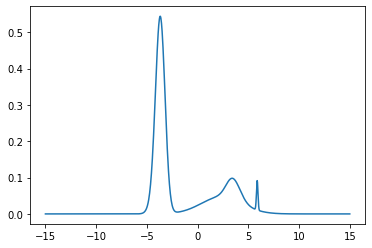

In [287]:
posterior_distribution = post(y_0)

t = tr.linspace(-15,15,1000)
plt.plot(t,posterior_distribution.log_prob(t).detach().exp())

In [528]:
**Problematically that is not that good**. This is because we trained it with samples from a standard normal prior! That is large values around 12 are unlikely to appear and thus we also do not observe y around 5 during training. So lets do this sequentially!

In [511]:
post = MDN(1,1,K=10,hidden_dim=100)
proposal = MDN(1,1,K=1,hidden_dim=100)
prior = distrib.Normal(0,1)

In [512]:
def SNRE_proposal(prior, y_0, step_data=200, iters=5, dim_x=1, dim_y=1):
    p_tilde = prior
    proposal = MDN(1,1,K=1, hidden_dim=20)
    for i in range(iters):
        X_i = p_tilde.sample_n(step_data)
        y_i = simulator(X_i)
        data_i = DataLoader(list(zip(X_i,y_i)), batch_size=10, shuffle=True)
        train(proposal, data_i, epochs=10)
        if i >= 1:
            p = proposal(y_0)
            new_mu_k, new_sigma_k, pi_k = adjust_gmm1d(p,p_tilde)
            mix = distrib.Categorical(probs=tr.tensor([1.]))
            comp = distrib.Normal(new_mu_k[0], new_sigma_k[0])
            p_tilde = distrib.MixtureSameFamily(mix, comp)
        else:
            p_tilde = proposal(y_0)
    return p_tilde

In [515]:
p_tilde = SNRE_proposal(prior,y_0)

In [529]:
X = p_tilde.sample_n(10000)
y = simulator(X)
data = DataLoader(list(zip(X,y)), batch_size=1000, shuffle=True)

In [530]:
train(post,data)

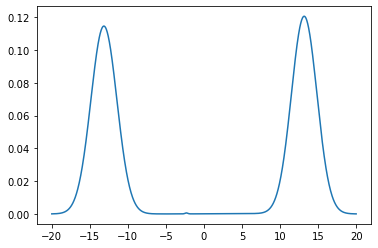

In [533]:
posterior_tilde = post(y_0)
new_mu_k, new_sigma_k, pi_k = adjust_gmm1d(posterior_tilde,p_tilde)
mix = distrib.Categorical(probs=tr.tensor(pi_k))
comp = distrib.Normal(new_mu_k, new_sigma_k)
posterior_distribution = distrib.MixtureSameFamily(mix, comp)

t = tr.linspace(-20,20,1000)
plt.plot(t,posterior_distribution.log_prob(t).detach().exp())

### Sources
* Papamakarios, G., & Murray, I. (2016). Fast $\epsilon $-free inference of simulation models with bayesian conditional density estimation. arXiv preprint arXiv:1605.06376.
* Lueckmann, J. M., Bassetto, G., Karaletsos, T., & Macke, J. H. (2019, January). Likelihood-free inference with emulator networks. In Symposium on Advances in Approximate Bayesian Inference (pp. 32-53). PMLR.ter :)